## Pair Programming - Regresión lineal 11

### Decision Tree

---

In [1]:
# Tratamiento de datos
import numpy as np
import pandas as pd

# Gráficos
import matplotlib.pyplot as plt
import seaborn as sns

# Modelado y evaluación
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV

# Configuración warnings
import warnings
warnings.filterwarnings('once')

In [6]:
plt.rcParams["figure.figsize"] = (15,5)
sns.set_palette("PiYG_r")

In [7]:
df= pd.read_csv('../archivos/metro_4.csv', index_col=0)

In [8]:
df.head(2)

,index,temp,rain_1h,snow_1h,clouds_all,weather_main,traffic_box,traffic_volume
0,0,0.738354,-0.13315,-0.032598,-0.753862,1,2101.064038,3539
1,1,0.619383,-0.13315,-0.032598,-1.241251,1,1681.830454,2784


In [9]:
df2 = df.drop(["index","traffic_volume"], axis=1)

En el pair programming de hoy debéis usar el csv que guardastéis cuando hicistéis el pairprgramming de codificicación (este csv debería tener las variables estadandarizas).

En pairprogramming anteriores ajustastéis vuestro datos a una regresión lineal. El objetivo de hoy es:

### 1. Ajustar el modelo a un Decision Tree

Separamos la variable respuesta de las predictoras

In [10]:
X = df2.drop("traffic_box", axis = 1)
y = df2["traffic_box"]

Dividimos los datos entre train y test

In [11]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

Ajustamos los datos al Decision Tree

In [12]:
arbol = DecisionTreeRegressor(random_state =0)

arbol.fit(x_train, y_train)

DecisionTreeRegressor(random_state=0)

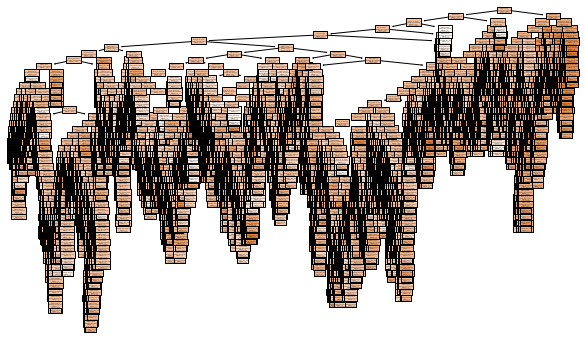

In [13]:
fig = plt.figure(figsize = (10,6))
tree.plot_tree(arbol, feature_names = x_train.columns, filled = True)
plt.show()

Una vez vemos que nuestro modelo es ilegible y tendrá overfitting pasamos ajustarlo

Sacamos las medidas features para ajustar las divisiones del metodo y que no tenga overfitting

In [14]:
max_features = np.sqrt(len(x_train.columns))
max_features

2.23606797749979

Sacamos la medición depth para ajustar la profundidad del algoritmo

In [15]:
print(arbol.tree_.max_depth)

51


Definimos el diccionario con los hiperparámetros

In [16]:
param = {"max_depth": [2,4,6], # Tenemos un máximo de 51 pero vamos a probar con una profundidad más pequeña
        "max_features": [1,2], # Ya que tenemos max_features de 2 y pocas columnas dejamos el límite en dos
        "min_samples_split": [20, 100, 200], # Como tenemos bastantes datos subimos el límite hasta 200 para la división de la madre
        "min_samples_leaf": [20,100, 200]} # Por el mismo razonamientos anterior subimos el límite hasta 200 para la división de los nodos

Utilizamos el método GridSearchCV

In [17]:
gs = GridSearchCV(
            estimator=DecisionTreeRegressor(), 
            param_grid= param, 
            cv=10, 
            verbose=-1,
            return_train_score = True,
            scoring="neg_mean_squared_error")

Fiteamos el train y el test con los parámetros definidos en el GridSearchCV 

In [18]:
gs.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [2, 4, 6], 'max_features': [1, 2],
                         'min_samples_leaf': [20, 100, 200],
                         'min_samples_split': [20, 100, 200]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=-1)

Sacamos la mejor estimación

In [19]:
mejor_modelo = gs.best_estimator_
mejor_modelo

DecisionTreeRegressor(max_depth=6, max_features=2, min_samples_leaf=100,
                      min_samples_split=100)

Sacamos la gráfica de nuestro primer decision tree

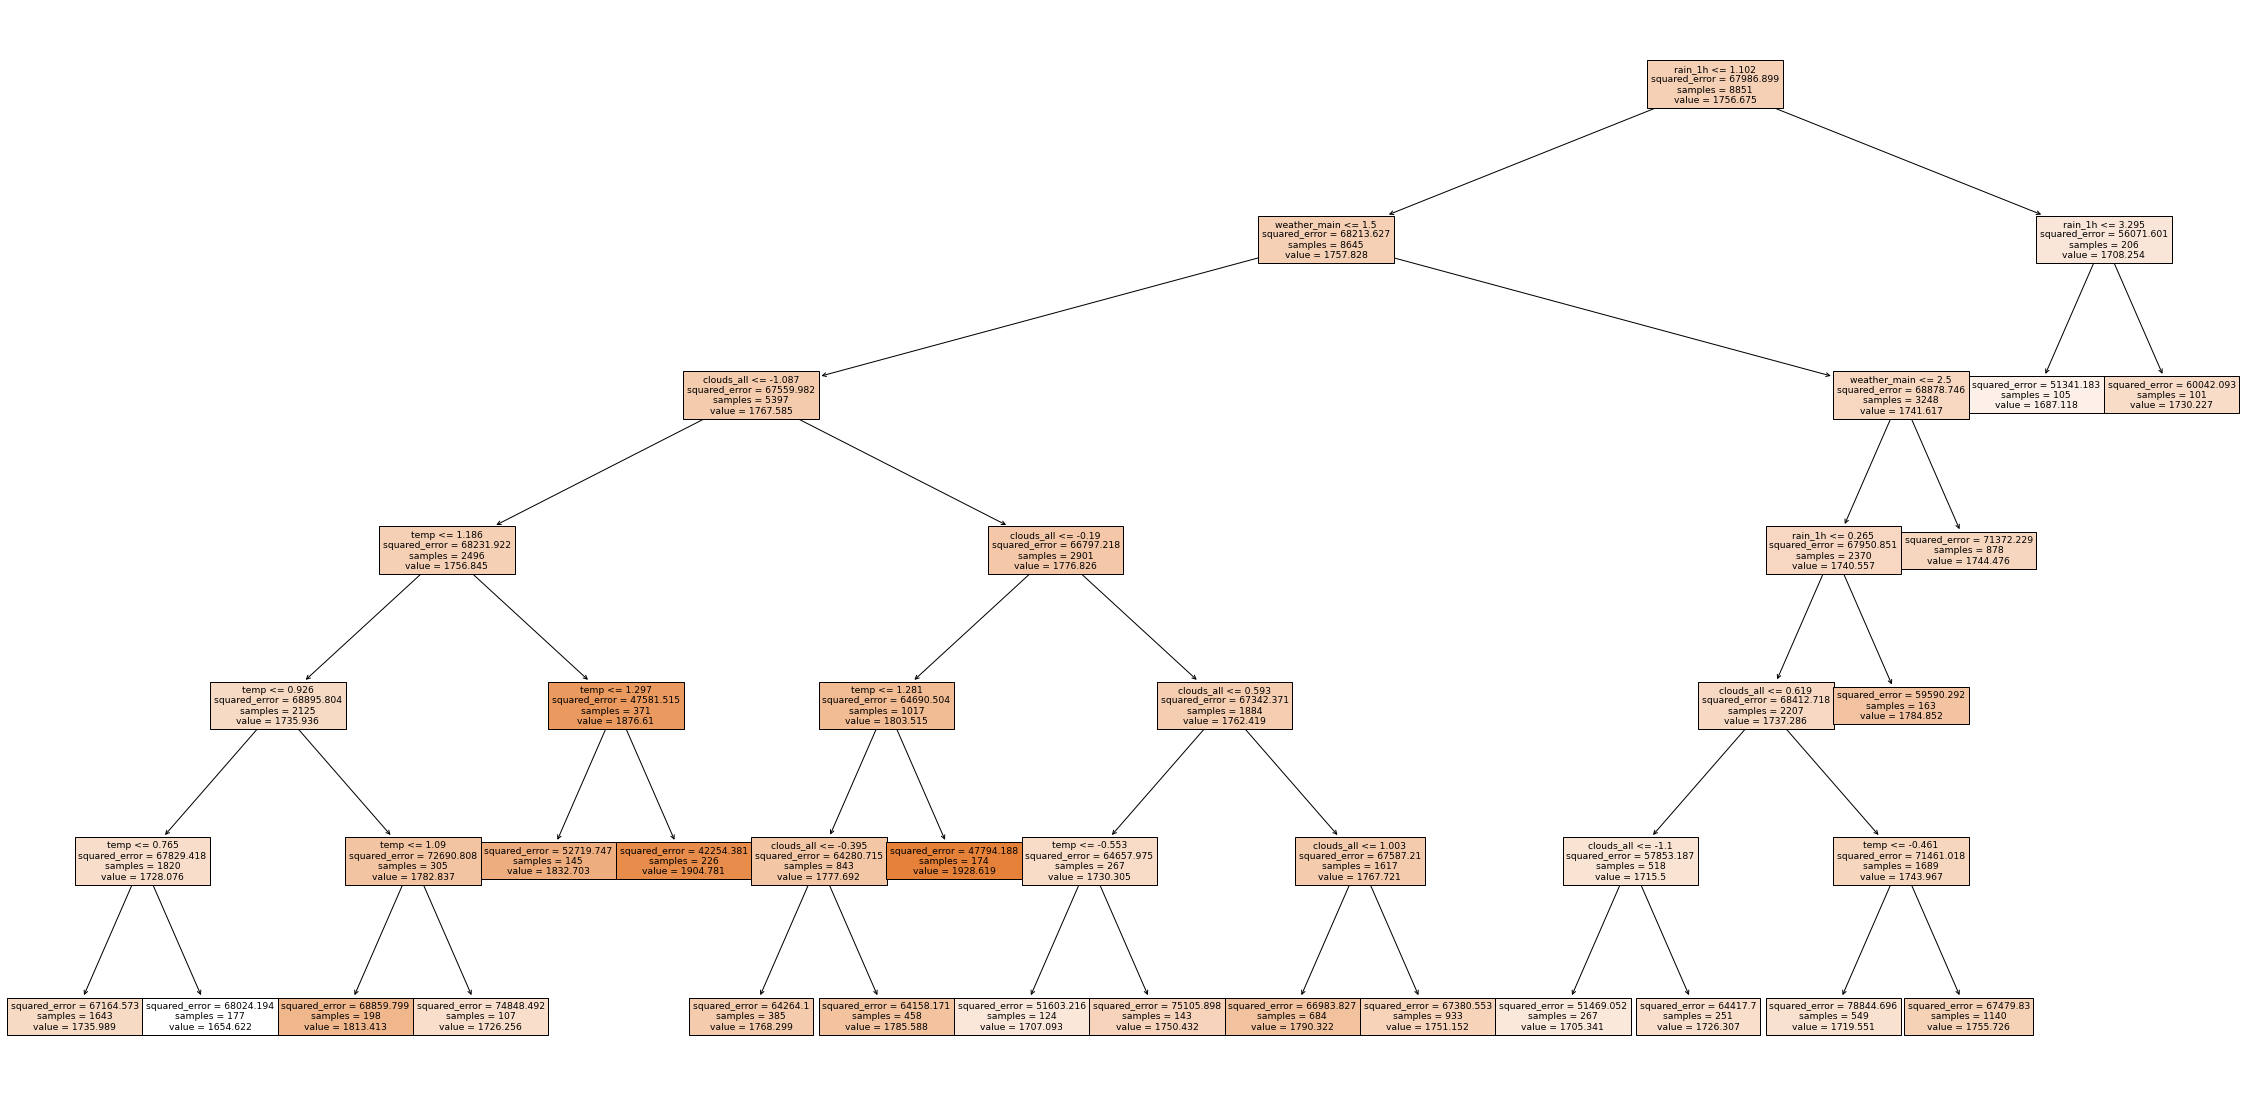

In [20]:
fig = plt.figure(figsize=(40, 20))
tree.plot_tree(mejor_modelo, feature_names=x_train.columns, filled=True);

Hacemos las predicciones y las juntamos en un df

In [21]:
y_pred_test_dt = mejor_modelo.predict(x_test)
y_pred_train_dt = mejor_modelo.predict(x_train)

In [22]:
predic_test_df= pd.DataFrame(y_pred_test_dt)
predic_train_df= pd.DataFrame(y_pred_train_dt)

In [45]:
predicciones = pd.concat([predic_train_df,predic_test_df], axis=1)
predicciones.columns = ["predic_train", "predic_test"]

In [46]:
predicciones.head(2)

,predic_train,predic_test
0,1751.152293,1735.988955
1,1735.988955,1654.622452


### 2. Extraer las métricas

Definimos la función para sacar las métricas y la usamos

In [26]:
def metricas(y_test, y_train, y_test_pred, y_train_pred, tipo_modelo):
    
    
    resultados = {'MAE': [mean_absolute_error(y_test, y_test_pred), mean_absolute_error(y_train, y_train_pred)],
                'MSE': [mean_squared_error(y_test, y_test_pred), mean_squared_error(y_train, y_train_pred)],
                'RMSE': [np.sqrt(mean_squared_error(y_test, y_test_pred)), np.sqrt(mean_squared_error(y_train, y_train_pred))],
                'R2':  [r2_score(y_test, y_test_pred), r2_score(y_train, y_train_pred)],
                 "set": ["test", "train"]}
    df = pd.DataFrame(resultados)
    df["modelo"] = tipo_modelo
    return df

In [27]:
dt_results = metricas(y_test, y_train, y_pred_test_dt, y_pred_train_dt, "Decision tree I")
dt_results


,MAE,MSE,RMSE,R2,set,modelo
0,210.059920,65485.03222,255.900434,0.018486,test,Decision tree I
1,212.616868,65919.07550,256.747104,0.030415,train,Decision tree I


_____________________

### 1.1 Probamos hacer unos cambios en nuestros hiperparámetros para ver si nuestro modelo se ajusta un poco mejor

In [28]:
param2 = {"max_depth": [2,10,18],
        "max_features": [1,2],
        "min_samples_split": [20, 80, 100],
        "min_samples_leaf": [50,200, 500]} 

In [29]:
gs2 = GridSearchCV(
            estimator=DecisionTreeRegressor(), 
            param_grid= param2, 
            cv=10, 
            verbose=-1,
            return_train_score = True,
            scoring="neg_mean_squared_error")

In [30]:
gs2.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [2, 10, 18], 'max_features': [1, 2],
                         'min_samples_leaf': [50, 200, 500],
                         'min_samples_split': [20, 80, 100]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=-1)

In [31]:
mejor_modelo2 = gs2.best_estimator_
mejor_modelo2

DecisionTreeRegressor(max_depth=18, max_features=2, min_samples_leaf=200,
                      min_samples_split=100)

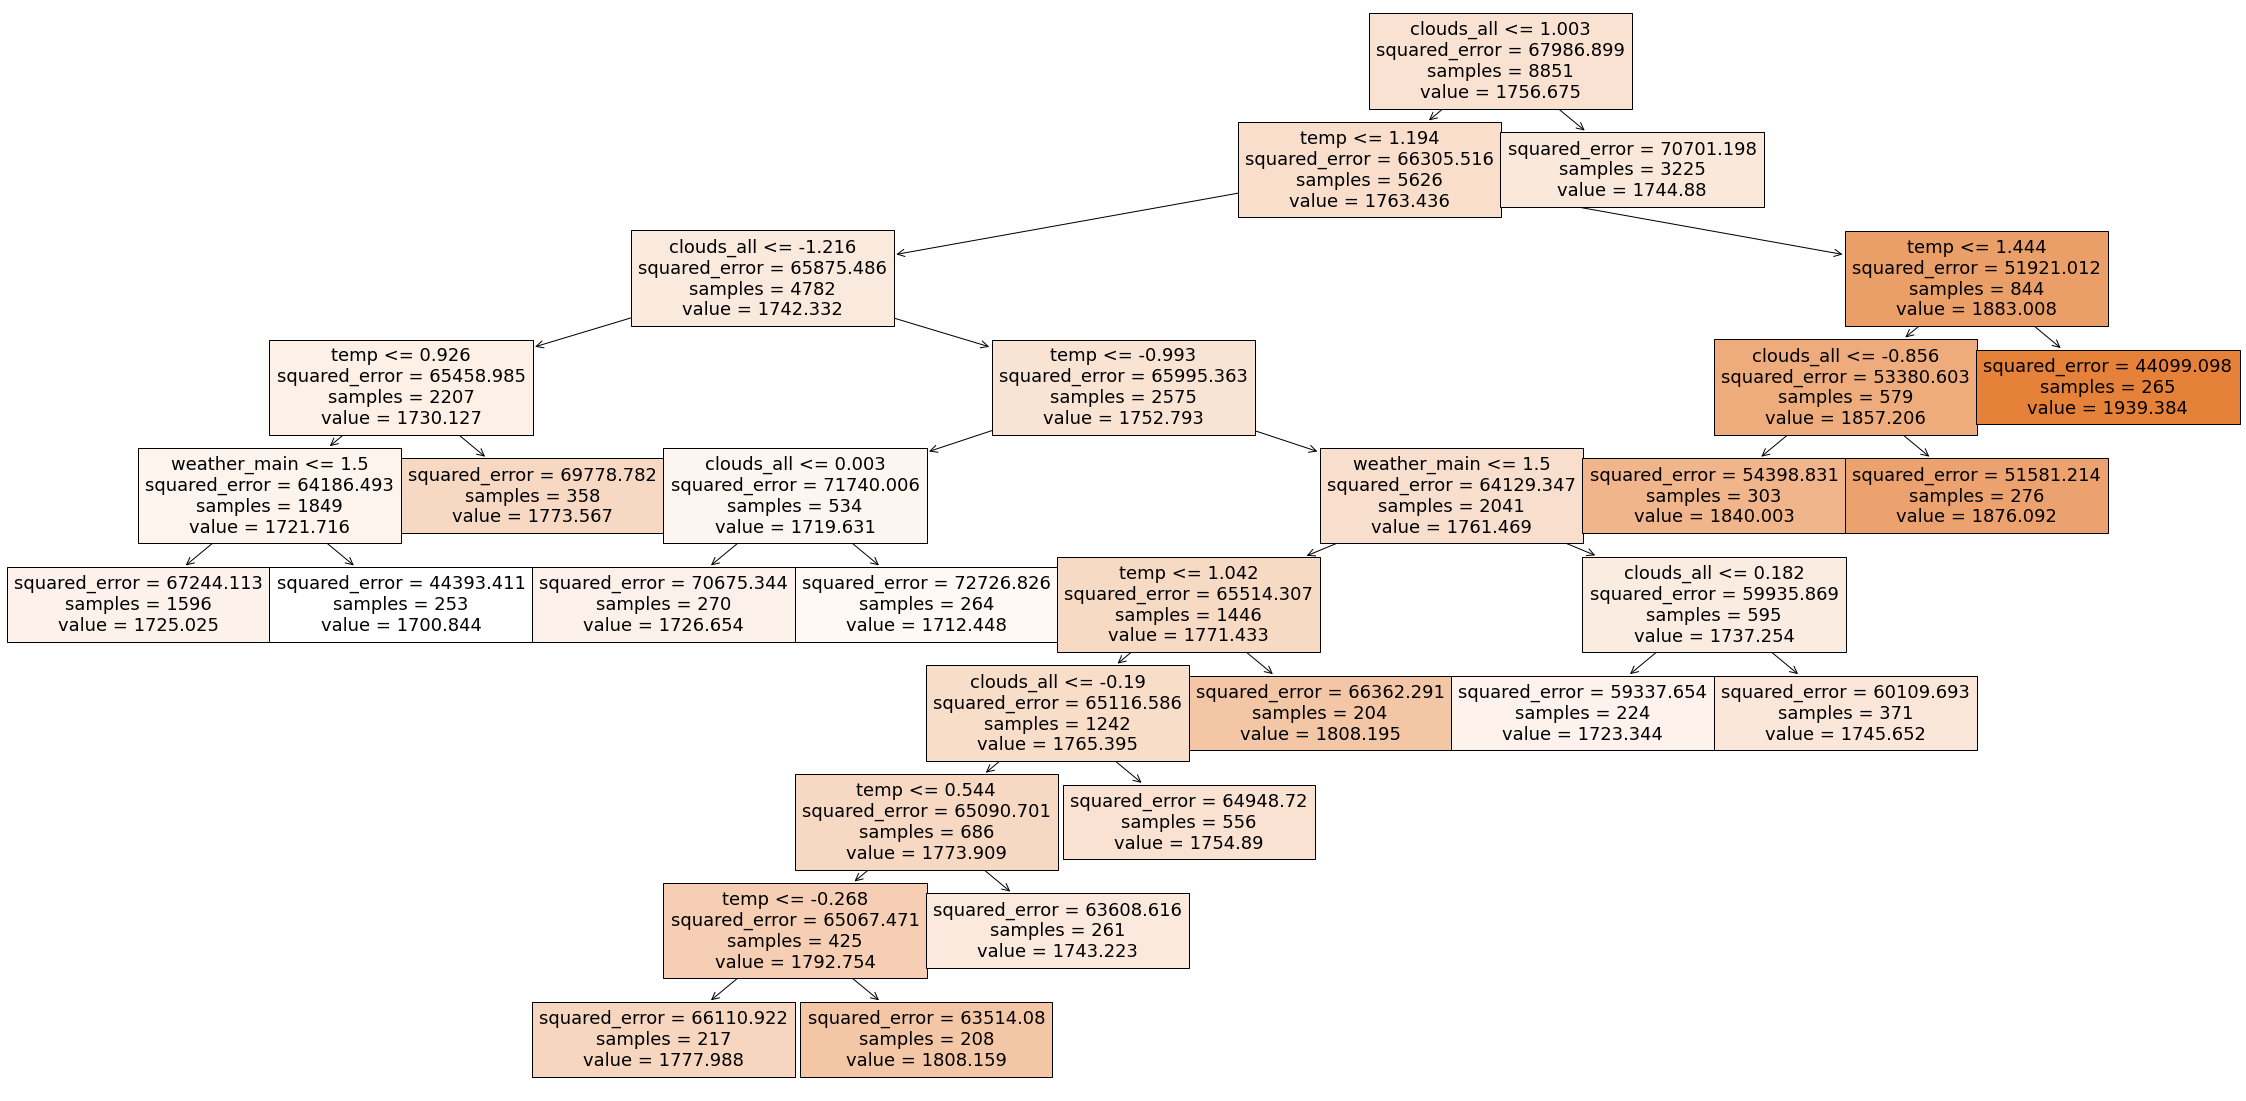

In [32]:
fig2 = plt.figure(figsize=(40, 20))
tree.plot_tree(mejor_modelo2, feature_names=x_train.columns, filled=True);

In [33]:
y_pred_test_dt2 = mejor_modelo2.predict(x_test)
y_pred_train_dt2 = mejor_modelo2.predict(x_train)

In [34]:
predic_test_df2= pd.DataFrame(y_pred_test_dt2)
predic_train_df2= pd.DataFrame(y_pred_train_dt2)

In [35]:
predicciones2 = pd.concat([predic_train_df2,predic_test_df2], axis=1)
predicciones2.columns = ["predic_train2", "predic_test2"]

In [36]:
predicciones2.head(2)

,predic_train2,predic_test2
0,1744.879801,1725.024818
1,1725.024818,1725.024818


### 2.1 Sacamos las métricas

In [37]:
dt_results2 = metricas(y_test, y_train, y_pred_test_dt2, y_pred_train_dt2, "Decision tree II")
dt_results2

,MAE,MSE,RMSE,R2,set,modelo
0,207.918147,64418.356952,253.807716,0.034474,test,Decision tree II
1,211.881448,65713.888337,256.347203,0.033433,train,Decision tree II


Traemos el df con los resultados de la Regresion Lineal 

In [38]:
df_linear_results = pd.read_csv("../archivos/resultados_metro_LR.csv", index_col = 0)
df_linear_results

,MAE,MSE,RMSE,R2,set,modelo
0,210.518843,65706.105082,256.332021,0.015172,test,Linear Regresion
1,214.320206,66978.132259,258.801337,0.014838,train,Linear Regression


### 3. Debatid entre vosotras que modelo es mejor y por qué (basándose en las métricas)

Concatenamos los dfs de los resultados de las métricas de los dos intentos de los Decision Tree y de la Linear Regresion

In [39]:
df_DT_LR_results = pd.concat([df_linear_results, dt_results, dt_results2], axis = 0)
df_DT_LR_results

,MAE,MSE,RMSE,R2,set,modelo
0,210.518843,65706.105082,256.332021,0.015172,test,Linear Regresion
1,214.320206,66978.132259,258.801337,0.014838,train,Linear Regression
0,210.059920,65485.032220,255.900434,0.018486,test,Decision tree I
1,212.616868,65919.075500,256.747104,0.030415,train,Decision tree I
0,207.918147,64418.356952,253.807716,0.034474,test,Decision tree II
1,211.881448,65713.888337,256.347203,0.033433,train,Decision tree II


Viendo las métricas que tenemos no podemos defender que sea un buen modelo de predicción, ya que el R2 es bajísimo, aunque haya subido con el 2º Decision Tree, y el RMSE también tiene unos valores fuera de lo que sería un modelo aceptable

### 4. Guardamos los resultados en un CSV

In [40]:
df_DT_LR_results.to_csv("../archivos/resultados_metro_LR_DT.csv")

### 5. Sacamos la importancia de las variables predictoras

Utilizamos el método feature_importances_ 

In [41]:
importancia_predictores = pd.DataFrame(
                            {'predictor': x_train.columns,
                             'importancia': mejor_modelo.feature_importances_}
                            )


# ordenamos de mayor a menor los resultados
importancia_predictores.sort_values(by=["importancia"], ascending=False, inplace = True)

# printeamos los resultados
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
0,temp,0.708839
3,clouds_all,0.164902
4,weather_main,0.075250
1,rain_1h,0.051010
2,snow_1h,0.000000


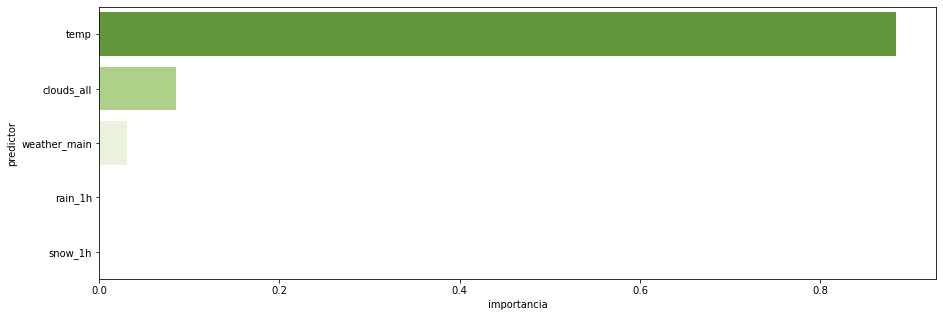

In [47]:
sns.barplot(x = "importancia", y = "predictor", data = importancia_predictores);
plt.show()

Sacamos la importancia también del segundo modelo

In [43]:
importancia_predictores = pd.DataFrame(
                            {'predictor': x_train.columns,
                             'importancia': mejor_modelo2.feature_importances_}
                            )


# ordenamos de mayor a menor los resultados
importancia_predictores.sort_values(by=["importancia"], ascending=False, inplace = True)

# printeamos los resultados
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
0,temp,0.884077
3,clouds_all,0.085098
4,weather_main,0.030825
1,rain_1h,0.000000
2,snow_1h,0.000000


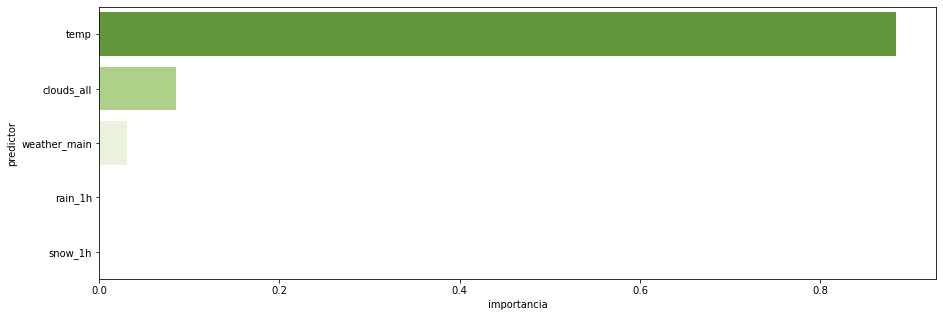

In [48]:
sns.barplot(x = "importancia", y = "predictor", data = importancia_predictores);
plt.show()